<a href="https://colab.research.google.com/github/ljkrajewski/jupyter_notebooks/blob/main/Hidream/Hidream_T2V_GGUF_Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From https://github.com/Isi-dev/Google-Colab_Notebooks/blob/main/Hidream_T2V_GGUF_Q5.ipynb

# **Hidream_GGUF_Q5 for Text to Image Generation**
- Choose one of the three HiDream model versions before setting up the environment.

- The notebook is divided into three sections for image generation, each pre-configured with the settings that have been used to get good results for its corresponding model version.

- The full version is much better than the others, but it took almost 21 minutes to generate an image with the default settings on the free T4 GPU.

In [ ]:
# @title Setup Environment
%cd /content
!pip install torch==2.6.0 torchvision==0.21.0

from IPython.display import clear_output
# !pip install -q torchsde einops diffusers accelerate xformers
# !git clone https://github.com/comfyanonymous/ComfyUI
!git clone https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
!git clone --branch forHidream https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI
# !apt -y install -qq aria2

import subprocess
import sys


def install_pip_packages():
    packages = [
        'torchsde',
        # 'av',
        'diffusers',
        # 'transformers',
        'xformers==0.0.29.post2',
        'accelerate',
        # 'omegaconf',
        # 'tqdm',
        # 'librosa',
        'einops'
    ]

    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")

# Run installations
print("Installing pip packages...")
install_pip_packages()
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")

import torch
import numpy as np
from PIL import Image
import gc
import os
sys.path.insert(0, '/content/ComfyUI')

from comfy import model_management

from nodes import (
    KSampler,
    VAEDecode,
    VAELoader,
    CLIPTextEncode,
    SaveImage
)

from custom_nodes.ComfyUI_GGUF.nodes import (
    UnetLoaderGGUF,
    QuadrupleCLIPLoaderGGUF
)
from comfy_extras.nodes_model_advanced import ModelSamplingSD3
from comfy_extras.nodes_sd3 import EmptySD3LatentImage

from pathlib import Path

def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False

hidream_version = "dev" # @param ["fast", "dev", "full"]

hidream_model = "hidream-i1-dev-Q5_0.gguf"

if hidream_version == "fast":
    hidream_model = model_download("https://huggingface.co/city96/HiDream-I1-Fast-gguf/resolve/main/hidream-i1-fast-Q5_0.gguf", "/content/ComfyUI/models/diffusion_models")
elif hidream_version == "full":
    hidream_model = model_download("https://huggingface.co/city96/HiDream-I1-Full-gguf/resolve/main/hidream-i1-full-Q5_0.gguf", "/content/ComfyUI/models/diffusion_models")
else:
    model_download("https://huggingface.co/city96/HiDream-I1-Dev-gguf/resolve/main/hidream-i1-dev-Q5_0.gguf", "/content/ComfyUI/models/diffusion_models")

clip_g = model_download("https://huggingface.co/Comfy-Org/HiDream-I1_ComfyUI/resolve/main/split_files/text_encoders/clip_g_hidream.safetensors", "/content/ComfyUI/models/text_encoders")
clip_l = model_download("https://huggingface.co/Comfy-Org/HiDream-I1_ComfyUI/resolve/main/split_files/text_encoders/clip_l_hidream.safetensors", "/content/ComfyUI/models/text_encoders")
llama = model_download("https://huggingface.co/calcuis/hidream-gguf/resolve/main/llama-q2_k.gguf", "/content/ComfyUI/models/text_encoders")
t5xxl = model_download("https://huggingface.co/city96/t5-v1_1-xxl-encoder-gguf/resolve/main/t5-v1_1-xxl-encoder-Q6_K.gguf", "/content/ComfyUI/models/text_encoders")
model_download("https://huggingface.co/Comfy-Org/HiDream-I1_ComfyUI/resolve/main/split_files/vae/ae.safetensors", "/content/ComfyUI/models/vae")

# Initialize nodes
unet_loader = UnetLoaderGGUF()
model_sampling = ModelSamplingSD3()
clip_loader = QuadrupleCLIPLoaderGGUF()
clip_encode_positive = CLIPTextEncode()
clip_encode_negative = CLIPTextEncode()
vae_loader = VAELoader()
empty_latent_image = EmptySD3LatentImage()
ksampler = KSampler()
vae_decode = VAEDecode()
save_image = SaveImage()

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()


def generate_image(
    positive_prompt: str = "anime girl with massive fennec ears and a big fluffy fox tail with long wavy blonde hair and blue eyes wearing a pink sweater a large oversized black winter coat and a long blue maxi skirt and large winter boots and a red scarf and large gloves sitting in a sled sledding fast down a snow mountain",
    negative_prompt: str = "bad ugly jpeg artifacts",
    width: int = 1024,
    height: int = 1024,
    seed: int = 147638433643733,
    steps: int = 28,
    cfg_scale: float = 1.0,
    sampler_name: str = "lcm",
    scheduler: str = "simple",
    shift: float = 6.0
):
    with torch.inference_mode():
        print("Loading CLIP models...")
        clip = clip_loader.load_clip(
            clip_g,
            clip_l,
            t5xxl,
            llama
        )[0]

        print("Encoding prompts...")
        positive = clip_encode_positive.encode(clip, positive_prompt)[0]
        negative = clip_encode_negative.encode(clip, negative_prompt)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        print("Creating empty latent...")
        empty_latent = empty_latent_image.generate(width, height, 1)[0]

        print("Loading UNet model...")
        model = unet_loader.load_unet(hidream_model)[0]
        model = model_sampling.patch(model, shift)[0]

        print("Generating Image...")
        sampled = ksampler.sample(
            model=model,
            seed=seed,
            steps=steps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive,
            negative=negative,
            latent_image=empty_latent
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()

        print("Loading VAE...")
        vae = vae_loader.load_vae("ae.safetensors")[0]

        try:
            print("Decoding image...")
            decoded = vae_decode.decode(vae, sampled)[0]

            del vae
            torch.cuda.empty_cache()
            gc.collect()

            print("Saving image...")
            output_path = save_image.save_images(decoded, "ComfyUI")["ui"]["images"][0]["filename"]
            full_path = f"/content/ComfyUI/output/{output_path}"

            from IPython.display import display, Image
            display(Image(filename=full_path))

            return full_path

        except Exception as e:
            print(f"Error during decoding/saving: {str(e)}")
            raise
        finally:
            clear_memory()

print("✅ Environment Setup Complete!")

# Example usage:
# generate_image()

Installation completed with status:
- All pip packages installed successfully
- apt packages installed successfully
✅ Environment Setup Complete!





---



---


---



**Use this section if you selected `fast` as the hidream_fp8_version** in "Setup Environment"

Using seed: 3431150532
Loading CLIP models...
Encoding prompts...
Creating empty latent...
Loading UNet model...
Generating Image...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading VAE...
Decoding image...
Saving image...


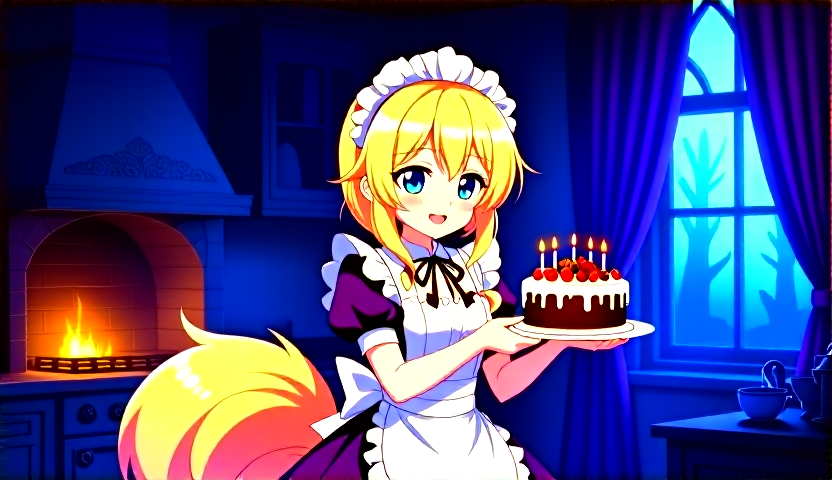

In [ ]:
# @title Generate Image (Fast Version)
positive_prompt = "" # @param {"type":"string"}
negative_prompt = "" # @param {"type":"string"}
width = 1440 # @param {"type":"integer", "min":512, "max":2048}
height = 720 # @param {"type":"integer", "min":512, "max":2048}
seed = 3431150532 # @param {"type":"integer"}
steps = 18 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 5.0 # @param {"type":"number", "min":0.1, "max":20.0}
sampler_name = "euler" # @param ["lcm", "uni_pc", "euler", "dpmpp_2m", "ddim", "lms"]
scheduler = "beta" # @param ["simple", "normal", "karras", "exponential", "beta", "ddim_uniform", "sgm_uniform"]
shift = 3.0 # @param {"type":"number", "min":0.0, "max":10.0}

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# Generate the image
output_path = generate_image(
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    seed=seed,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    shift=shift
)




---

---



---







**Use this section if you selected `dev` as the hidream_fp8_version** in "Setup Environment"

Using seed: 852156985
Loading CLIP models...


Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors


Encoding prompts...
Creating empty latent...
Loading UNet model...
Generating Image...


  0%|          | 0/20 [00:00<?, ?it/s]

Loading VAE...
Decoding image...
Saving image...


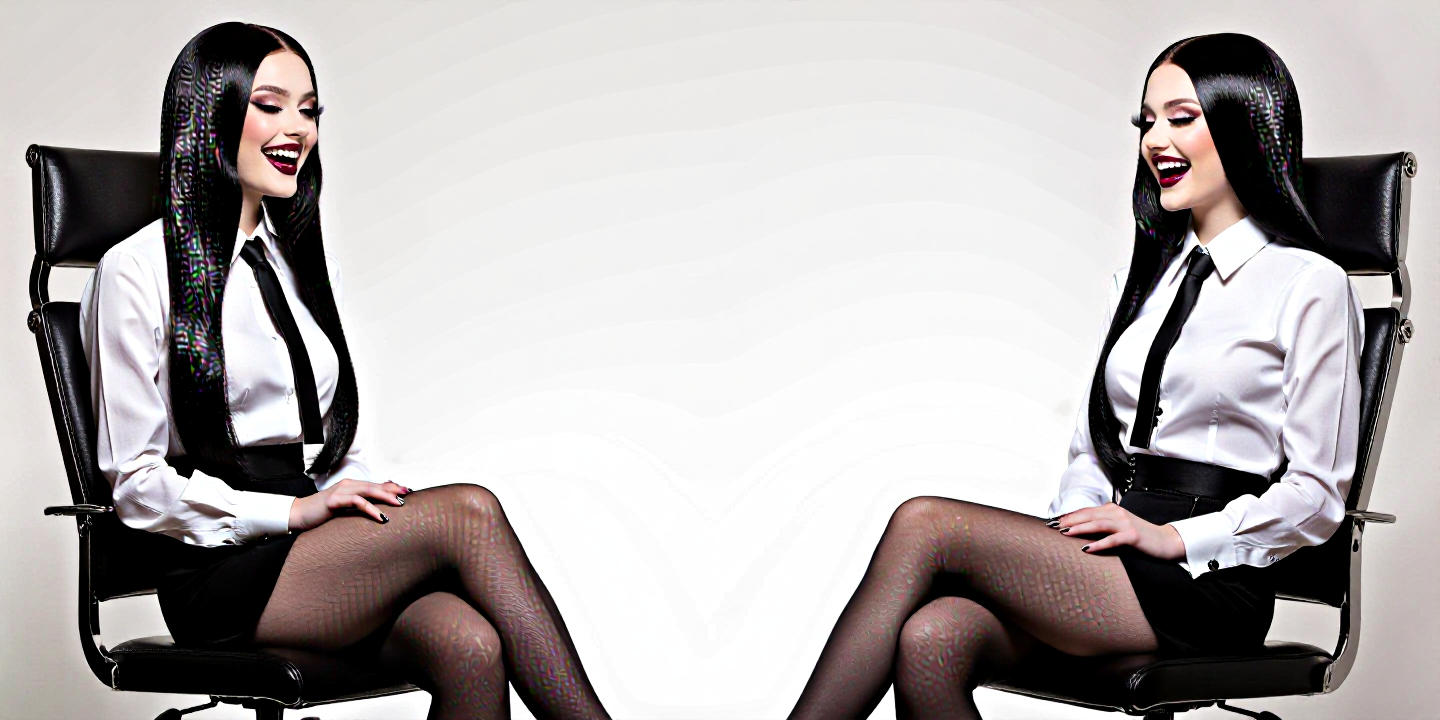

In [ ]:
# @title Generate Image (Dev Version)
positive_prompt = "Realistic photograph, full-body portrait, side view, slender and striking 19-year-old Caucasian woman, intense Gothic aesthetic, long sleek jet-black hair, porcelain-pale skin, bold black lipstick, wearing a crisp white button-up blouse, black necktie, black suspenders, tailored black suit jacket, fitted black shorts, sheer tan pantyhose, polished black flat shoes, sitting in an orthodontic chair, laughing, giggling with a dreamy, anesthesia-induced haze, intricate details, realistic shading, moody and slightly surreal atmosphere" # @param {"type":"string"}
negative_prompt = "bad ugly jpeg artifacts blurry, extra limbs, distorted face, bad anatomy, low resolution, out of frame, cropped, low detail, unrealistic proportions, artifacts, dull" # @param {"type":"string"}
width = 1440 # @param {"type":"integer", "min":512, "max":2048}
height = 720 # @param {"type":"integer", "min":512, "max":2048}
seed = 852156985 # @param {"type":"integer"}
steps = 20 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 7.0 # @param {"type":"number", "min":0.1, "max":20.0}
sampler_name = "euler" # @param ["lcm", "uni_pc", "euler", "dpmpp_2m", "ddim", "lms"]
scheduler = "beta" # @param ["simple", "normal", "karras", "exponential", "beta", "ddim_uniform", "sgm_uniform"]
shift = 6.0 # @param {"type":"number", "min":0.0, "max":10.0}

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# Generate the image
output_path = generate_image(
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    seed=seed,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    shift=shift
)



---



---



---



**Use this section if you selected `full` as the hidream_fp8_version** in "Setup Environment"

Using seed: 851630199566201
Loading CLIP models...
Encoding prompts...
Creating empty latent...
Loading UNet model...
Generating Image...


  0%|          | 0/25 [00:00<?, ?it/s]

Loading VAE...
Decoding image...
Saving image...


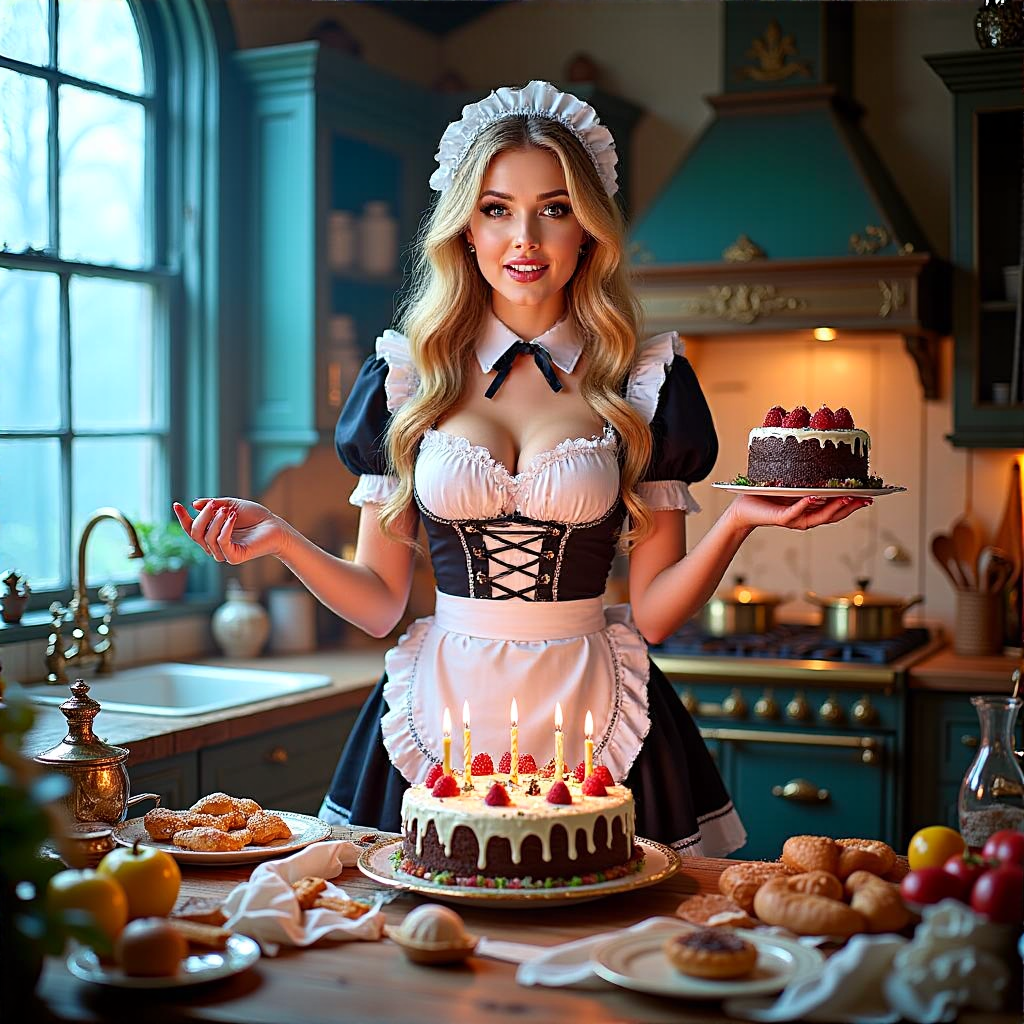

In [ ]:
# @title Generate Image (Full Version)
positive_prompt = "a beautiful 25-year-old curvy and busty blonde woman with long wavy hair wearing a maid outfit with a long black gold leaf pattern dress and a white apron mouth open holding a fancy black forest cake with candles on top in the kitchen of an old dark Victorian mansion lit by candlelight with a bright window to the foggy forest and very expensive stuff everywhere" # @param {"type":"string"}
negative_prompt = "" # @param {"type":"string"}
width = 1024 # @param {"type":"integer", "min":512, "max":2048}
height = 1024 # @param {"type":"integer", "min":512, "max":2048}
seed = 851630199566201 # @param {"type":"integer"}
steps = 25 # @param {"type":"integer", "min":1, "max":100}
cfg_scale = 5.0 # @param {"type":"number", "min":0.1, "max":20.0}
sampler_name = "euler" # @param ["lcm", "uni_pc", "euler", "dpmpp_2m", "ddim", "lms"]
scheduler = "beta" # @param ["simple", "normal", "karras", "exponential", "beta", "ddim_uniform", "sgm_uniform"]
shift = 3.0 # @param {"type":"number", "min":0.0, "max":10.0}

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# Generate the image
output_path = generate_image(
    positive_prompt=positive_prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    seed=seed,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    shift=shift
)